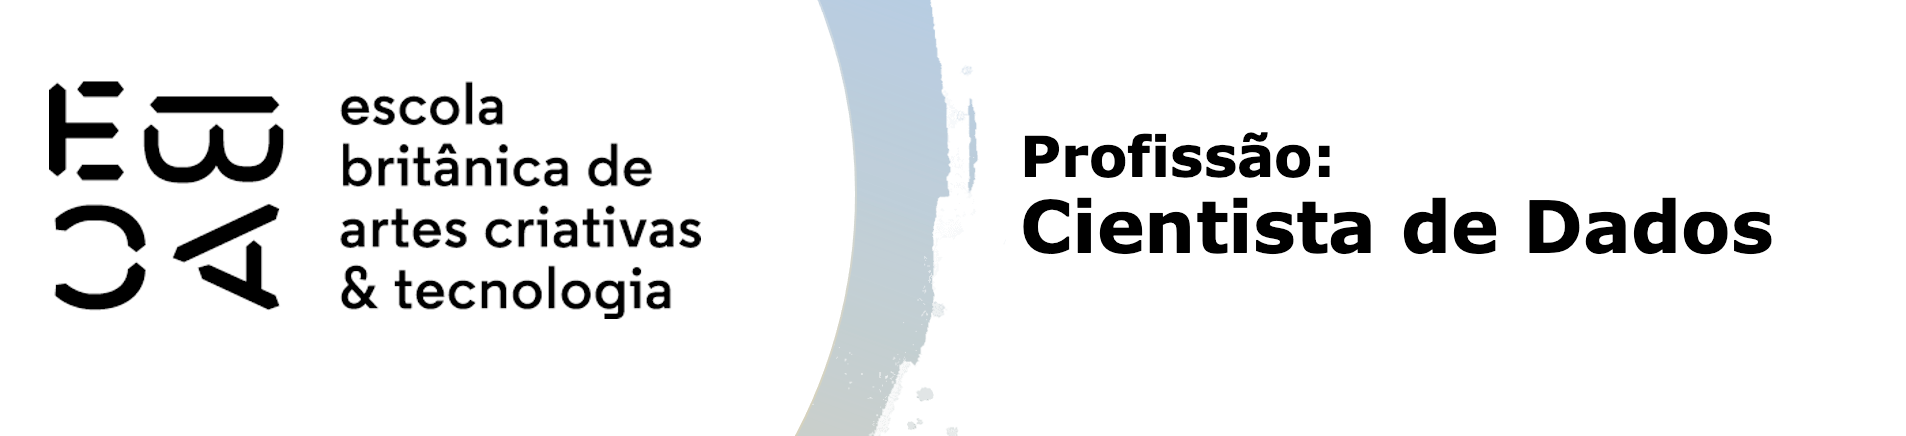

# Tarefa

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos. 

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado nas primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente que de características da página o da época do ano.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [3]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import math
import warnings

In [4]:
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv(r'C:\Users\Joel\Downloads\Data Scientist\Mod 29\online_shoppers_intention.csv')

In [6]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [7]:
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [9]:
# Selecionar as variáveis de comportamento de navegação
features = df[['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration']]


In [10]:
df.dtypes


Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

Valores ausentes nas variáveis:
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
dtype: int64
Análise descritiva das variáveis:
       Administrative  Administrative_Duration  Informational  \
count    12330.000000             12330.000000   12330.000000   
mean         2.315166                80.818611       0.503569   
std          3.321784               176.779107       1.270156   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000                 7.500000       0.000000   
75%          4.000000                93.256250       0.000000   
max         27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  
count            12330.000000    12330.000000             12330.000000  
mean           

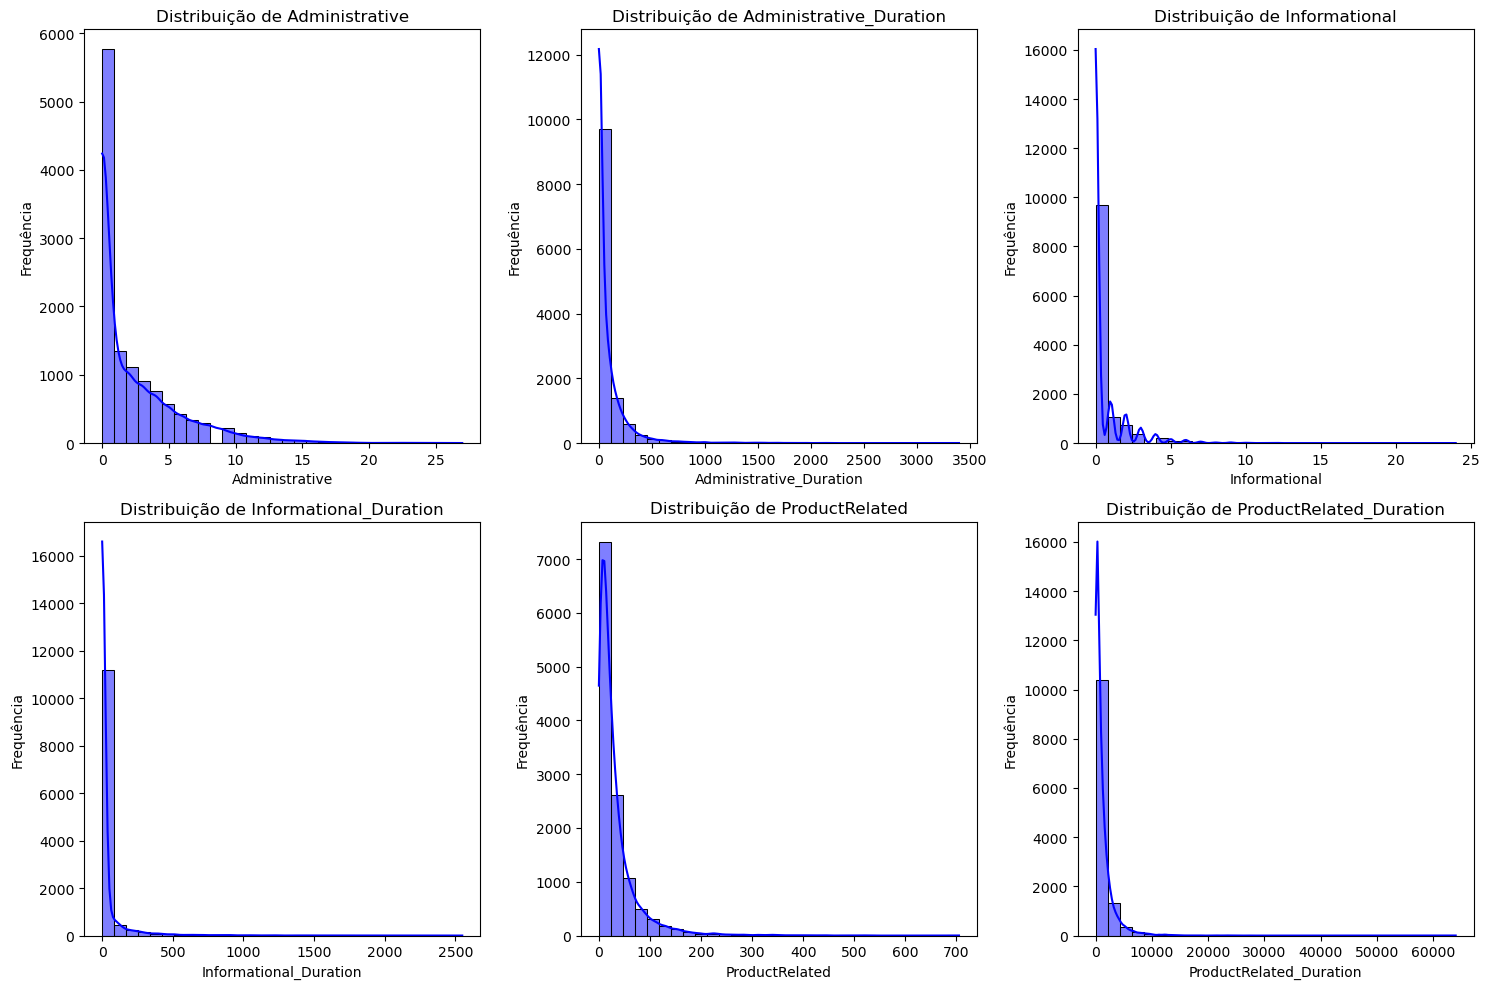

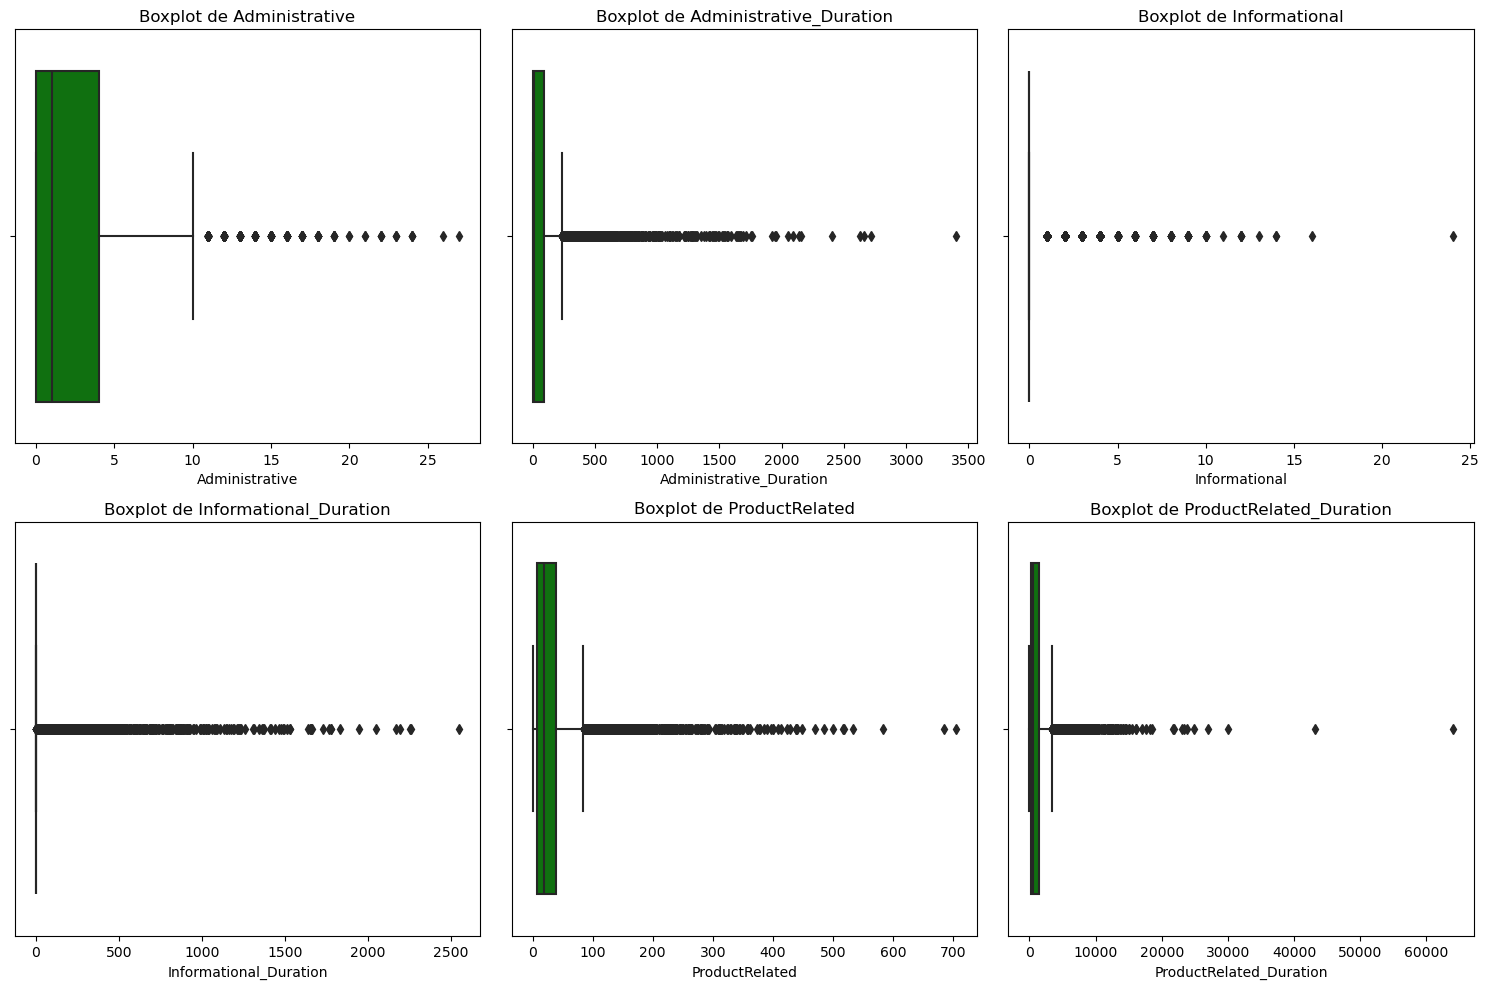

In [11]:
# 1. Verificação de missing values
missing_values = features.isnull().sum()
print(f"Valores ausentes nas variáveis:\n{missing_values}")

# Caso haja valores missing, tratá-los de forma robusta:
if missing_values.sum() > 0:
    # Preencher valores ausentes com a mediana (para numéricas) ou o valor mais frequente (para categóricas)
    for col in features.columns:
        if features[col].dtype in ['float64', 'int64']:
            features[col].fillna(features[col].median(), inplace=True)
        else:
            features[col].fillna(features[col].mode()[0], inplace=True)

# Atualizar o DataFrame para refletir os valores imputados
features_imputed = features.copy()

# 2. Análise descritiva das variáveis
descriptive_stats = features_imputed.describe(include='all')
print(f"Análise descritiva das variáveis:\n{descriptive_stats}")

# 3. Visualização das distribuições
# Determinar número de colunas numéricas
num_cols = len(features_imputed.select_dtypes(include=['float64', 'int64']).columns)
num_rows = math.ceil(num_cols / 3)  # Número de linhas baseado em 3 colunas por linha

plt.figure(figsize=(15, 5 * num_rows))  # Ajustar o tamanho da figura

for i, column in enumerate(features_imputed.select_dtypes(include=['float64', 'int64']).columns, 1):
    plt.subplot(num_rows, 3, i)  # Layout dinâmico
    sns.histplot(features_imputed[column], kde=True, color='blue', bins=30)
    plt.title(f'Distribuição de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

# 4. Verificar outliers com boxplots
plt.figure(figsize=(15, 5 * num_rows))  # Ajustar o tamanho da figura

for i, column in enumerate(features_imputed.select_dtypes(include=['float64', 'int64']).columns, 1):
    plt.subplot(num_rows, 3, i)  # Layout dinâmico
    sns.boxplot(x=features_imputed[column], color='green')
    plt.title(f'Boxplot de {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

## Número de grupos

Utilize as técnicas vistas em aula que te ajudem a decidir pelo número de grupos a ser utilizados.

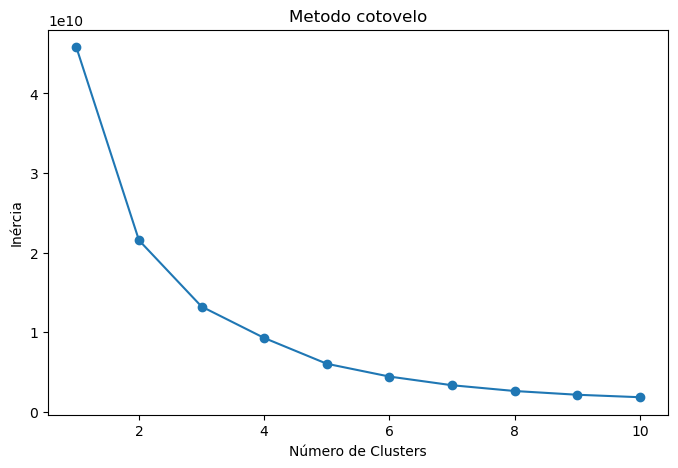

In [14]:
# Determinando o número ideal de clusters (Metodo cotovelo)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_imputed)
    inertia.append(kmeans.inertia_)

# Plotando o Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Metodo cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.show()

Calculando silhuetas: 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

Número ideal de clusters: 2


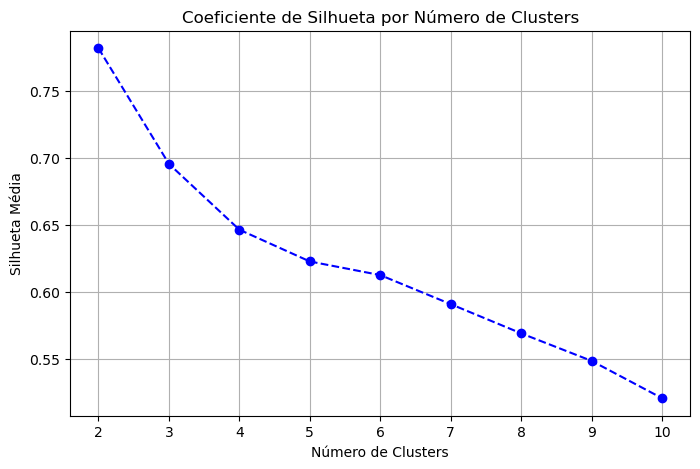

In [15]:
# Lista para armazenar os valores médios da silhueta
silhouette_avg = []

# Número máximo de clusters a testar
max_clusters = 10

# Loop para testar diferentes números de clusters
for n_clusters in tqdm(range(2, max_clusters + 1), desc="Calculando silhuetas"):
    # Ajustar o modelo K-means com o número atual de clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)

    # Calcular o coeficiente médio de silhueta
    score = silhouette_score(features, kmeans.labels_)
    silhouette_avg.append(score)

# Determinar o número ideal de clusters
optimal_clusters = range(2, max_clusters + 1)[silhouette_avg.index(max(silhouette_avg))]
print(f"Número ideal de clusters: {optimal_clusters}")

# Plotar o coeficiente de silhueta
plt.figure(figsize=(8, 5))
plt.plot(range(2, max_clusters + 1), silhouette_avg, marker='o', linestyle='--', color='b')
plt.title("Coeficiente de Silhueta por Número de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Silhueta Média")
plt.xticks(range(2, max_clusters + 1))
plt.grid(True)
plt.show()

In [17]:
# Padronizar os dados (normalização)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(features_imputed)

# Aplicar o algoritmo K-Means (usando, por exemplo, 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_scaled)
labels = kmeans.labels_

# Calcular o Coeficiente de Silhueta
silhouette_avg = silhouette_score(data_scaled, labels)
print(f"Coeficiente de Silhueta (média): {silhouette_avg}")

Coeficiente de Silhueta (média): 0.5046756548677888


## Avaliação dos grupos

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.


### Análise Descritiva para 3 Clusters ###

           Administrative  Administrative_Duration  Informational  \
Cluster_3                                                           
0                6.523289               251.030033       0.973674   
1                7.058201               266.421802       4.086420   
2                0.907898                24.277938       0.160103   

           Informational_Duration  ProductRelated  ProductRelated_Duration  
Cluster_3                                                                   
0                       42.301835       55.539490              2056.320976  
1                      458.371554      138.380952              5731.105279  
2                        6.531608       18.900366               689.114236  


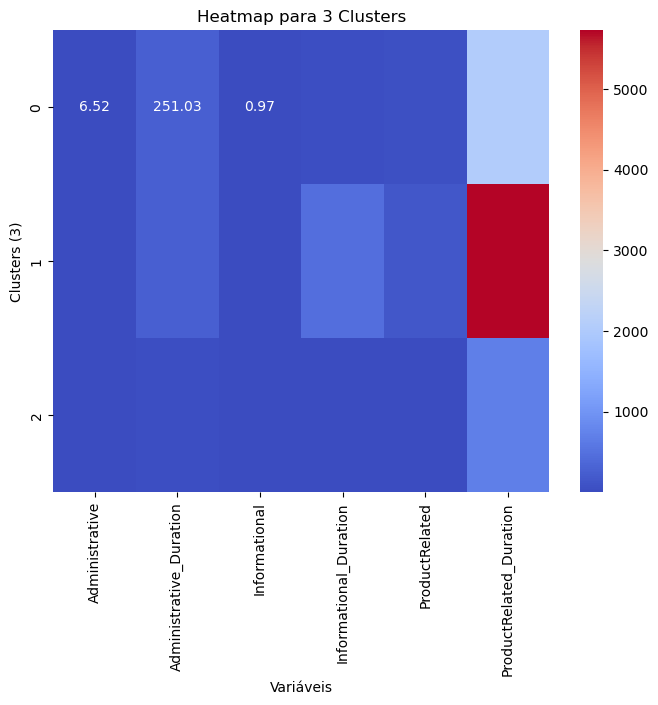


### Análise Descritiva para 4 Clusters ###

           Administrative  Administrative_Duration  Informational  \
Cluster_4                                                           
0                6.663457               260.887953       0.729978   
1                5.584055               194.262921       4.306759   
2                0.876654                23.316800       0.157192   
3                8.068000               293.362104       2.428000   

           Informational_Duration  ProductRelated  ProductRelated_Duration  
Cluster_4                                                                   
0                       26.768616       53.029322              1952.814380  
1                      466.857194       59.655113              2462.010839  
2                        5.507445       19.062920               696.814243  
3                      174.936582      239.736000              9700.904340  


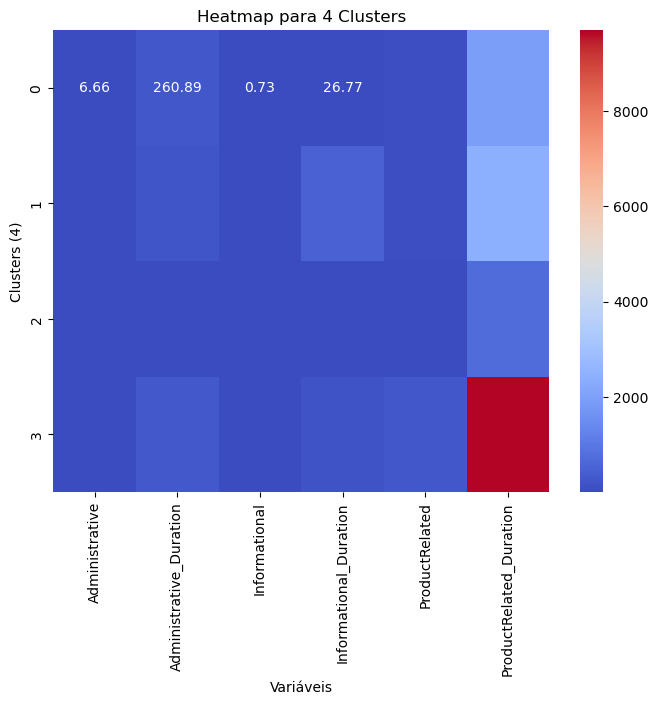


Sugestão de nomes para os clusters com base na análise descritiva:

Para 3 clusters:
Cluster 0: ProductRelated_Duration (baseado na maior média)
Cluster 1: ProductRelated_Duration (baseado na maior média)
Cluster 2: ProductRelated_Duration (baseado na maior média)

Para 4 clusters:
Cluster 0: ProductRelated_Duration (baseado na maior média)
Cluster 1: ProductRelated_Duration (baseado na maior média)
Cluster 2: ProductRelated_Duration (baseado na maior média)
Cluster 3: ProductRelated_Duration (baseado na maior média)


In [19]:
# Normalizar os dados para garantir que o K-means funcione bem
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

# Definir os dois números de clusters escolhidos para análise
clusters_to_analyze = [3, 4]

# Dicionário para armazenar os agrupamentos
cluster_results = {}

# Criar os agrupamentos e realizar a análise descritiva
for n_clusters in clusters_to_analyze:
    # Ajustar o modelo K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features_scaled)
    
    # Adicionar os rótulos ao DataFrame para análise
    features_with_clusters = features.copy()
    features_with_clusters[f'Cluster_{n_clusters}'] = labels
    
    # Análise descritiva por cluster
    descriptive_stats = features_with_clusters.groupby(f'Cluster_{n_clusters}').mean()
    cluster_results[n_clusters] = descriptive_stats
    
    # Exibir a análise descritiva
    print(f"\n### Análise Descritiva para {n_clusters} Clusters ###\n")
    print(descriptive_stats)
    
    # Visualização dos clusters
    plt.figure(figsize=(8, 6))
    sns.heatmap(descriptive_stats, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f'Heatmap para {n_clusters} Clusters')
    plt.xlabel('Variáveis')
    plt.ylabel(f'Clusters ({n_clusters})')
    plt.show()

# Sugestão de nomes para os clusters com base na análise descritiva
print("\nSugestão de nomes para os clusters com base na análise descritiva:")
for n_clusters, stats in cluster_results.items():
    print(f"\nPara {n_clusters} clusters:")
    for cluster_id, row in stats.iterrows():
        print(f"Cluster {cluster_id}: {row.idxmax()} (baseado na maior média)")

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?


### Análise por Cluster ###

         BounceRates   Revenue  Clientes
Cluster                                 
0           0.006677  0.218959      2690
1           0.007683  0.271127       568
2           0.028970  0.118875      8572
3           0.005324  0.347280       239
4           0.006465  0.241379       261


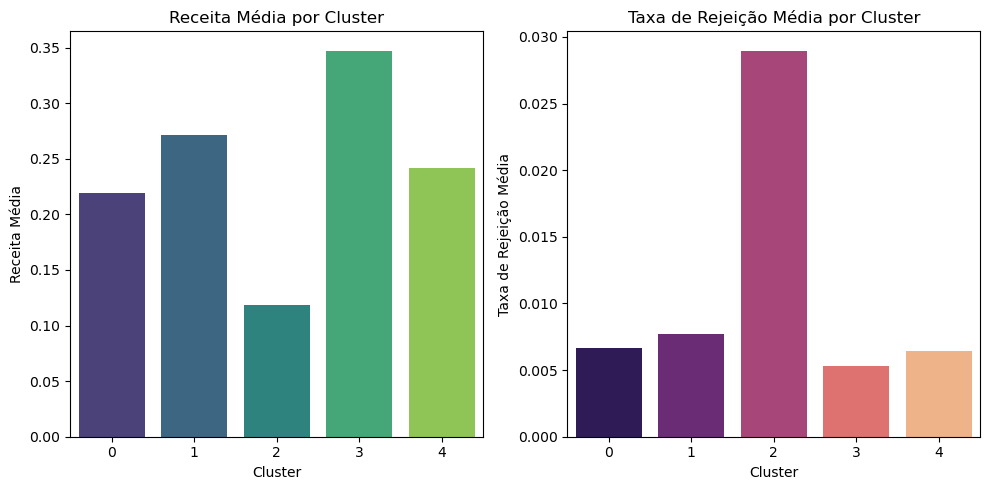

In [37]:
data_with_clusters = df.copy()

# Adicionar os rótulos dos clusters (por exemplo, com 3 clusters)
data_with_clusters['Cluster'] = KMeans(n_clusters=5, random_state=42).fit_predict(features_scaled)

# Análise descritiva das variáveis externas por cluster
cluster_analysis = data_with_clusters.groupby('Cluster')[['BounceRates', 'Revenue']].mean()

# Adicionar contagem de clientes em cada cluster
cluster_analysis['Clientes'] = data_with_clusters['Cluster'].value_counts()

# Exibir os resultados
print("\n### Análise por Cluster ###\n")
print(cluster_analysis)

# Visualização dos resultados
plt.figure(figsize=(10, 5))

# Receita por cluster
plt.subplot(1, 2, 1)
sns.barplot(x=cluster_analysis.index, y=cluster_analysis['Revenue'], palette='viridis')
plt.title('Receita Média por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Receita Média')

# Taxa de rejeição por cluster
plt.subplot(1, 2, 2)
sns.barplot(x=cluster_analysis.index, y=cluster_analysis['BounceRates'], palette='magma')
plt.title('Taxa de Rejeição Média por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Taxa de Rejeição Média')

plt.tight_layout()
plt.show()

<span style="color:red;">Estou bem confuso nesse modulo, ao qual não entendi o que quer que eu faça usando a taxa de rejeição e receita, para descobrir qual clientes compra mais? Como faço para descobrir a taxa de rejeição e receita com as variaveis que tenho no dataframe.</span>


### Análise Descritiva para 3 Clusters ###

           BounceRates   Revenue  Clientes
Cluster_3                                 
1             0.006750  0.306878       567
0             0.006500  0.231268      2469
2             0.027302  0.125134      9294

### Análise Descritiva para 4 Clusters ###

           BounceRates   Revenue  Clientes
Cluster_4                                 
3             0.005382  0.348000       250
1             0.007625  0.266898       577
0             0.006470  0.228009      2285
2             0.027456  0.124322      9218

### Grupos mais propensos à compra ###

Para 3 clusters, o grupo mais propenso à compra é o Cluster 1 com Receita Média de 0.31.
Para 4 clusters, o grupo mais propenso à compra é o Cluster 3 com Receita Média de 0.35.


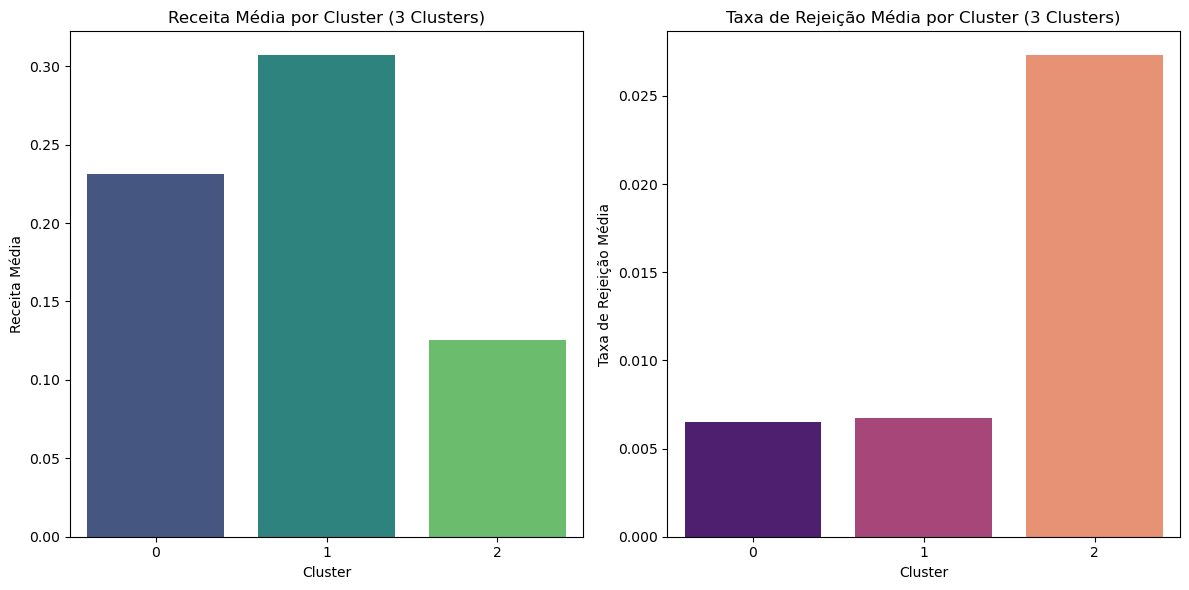

In [32]:
# 1. Adicionar variáveis externas após padronização
data_with_clusters = pd.DataFrame(features_scaled, columns=features.columns)
data_with_clusters[['Revenue', 'BounceRates']] = df[['Revenue', 'BounceRates']]

# 2. Definir os números de clusters a serem analisados
clusters_to_analyze = [3, 4]

# 3. Dicionário para armazenar análises descritivas
cluster_results = {}

for n_clusters in clusters_to_analyze:
    # Ajustar o modelo K-means e adicionar rótulos ao DataFrame
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data_with_clusters[f'Cluster_{n_clusters}'] = kmeans.fit_predict(features_scaled)
    
    # Análise descritiva por cluster
    cluster_analysis = (
        data_with_clusters.groupby(f'Cluster_{n_clusters}')[['BounceRates', 'Revenue']]
        .mean()
        .sort_values('Revenue', ascending=False)
    )
    
    # Contagem de clientes por cluster
    cluster_analysis['Clientes'] = data_with_clusters[f'Cluster_{n_clusters}'].value_counts().sort_index()
    
    # Armazenar os resultados
    cluster_results[n_clusters] = cluster_analysis
    
    # Exibir os resultados
    print(f"\n### Análise Descritiva para {n_clusters} Clusters ###\n")
    print(cluster_analysis)

# 4. Identificar grupos mais propensos à compra
print("\n### Grupos mais propensos à compra ###\n")
for n_clusters, analysis in cluster_results.items():
    top_cluster = analysis['Revenue'].idxmax()
    print(f"Para {n_clusters} clusters, o grupo mais propenso à compra é o Cluster {top_cluster} com Receita Média de {analysis.loc[top_cluster, 'Revenue']:.2f}.")

# 5. Visualização da Receita e Taxa de Rejeição por cluster para 3 clusters
plt.figure(figsize=(12, 6))

# Receita por cluster
plt.subplot(1, 2, 1)
sns.barplot(x=cluster_results[3].index, y=cluster_results[3]['Revenue'], palette='viridis')
plt.title('Receita Média por Cluster (3 Clusters)')
plt.xlabel('Cluster')
plt.ylabel('Receita Média')

# Taxa de rejeição por cluster
plt.subplot(1, 2, 2)
sns.barplot(x=cluster_results[3].index, y=cluster_results[3]['BounceRates'], palette='magma')
plt.title('Taxa de Rejeição Média por Cluster (3 Clusters)')
plt.xlabel('Cluster')
plt.ylabel('Taxa de Rejeição Média')

plt.tight_layout()
plt.show()